In [1]:
#Library imports for torch

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Setting torch seed to manual
torch.manual_seed(10)

In [2]:
#Gaussian Noise Transformation and DataLoader implementation 

import random

def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.3
    
    if torch.rand(1) < 0.5:
        return img
    
    out = img + sigma * torch.randn_like(img)
    
    out = out.clamp(0, 1)
    #print(out)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out


transform = transforms.Compose(
    [transforms.ToTensor(),
     gauss_noise_tensor,
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

noisy_trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
noisy_trainloader = torch.utils.data.DataLoader(noisy_trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)


classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CNN network implementation for deepproblog

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.MINST = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2, 2),  # 6 24 24 -> 6 12 12
            nn.ReLU(True),
            nn.Conv2d(6, 16, 5),  # 6 12 12 -> 16 8 8
            nn.MaxPool2d(2, 2),  # 16 8 8 -> 16 4 4
            nn.ReLU(True),
        )
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.MINST(x)
        x = self.softmax(x)
        return x
    
net = Net()

In [4]:
# Deepproblog dataset class implementation for formatting tensor data to query terms

from deepproblog.dataset import Dataset
from deepproblog.query import Query
from problog.logic import Term, Constant, Not

class CIFAR10Dataset(Dataset):
    def __init__(self, dataset_name: str, dataset):
        super(CIFAR10Dataset).__init__()
        
        self.dataset_name = dataset_name
        self.dataset = dataset.dataset
        
    def __getitem__(self, index):
        
        return self.dataset[int(index[0])][0]
        
    def to_query(self, i):
        
        def num_to_label(num):
            dictionary = {
            0:"plane",
            1:"car",
            2:"bird",
            3:"cat",
            4:"deer",
            5:"dog",
            6:"frog",
            7:"horse",
            8:"ship",
            9:"truck" }
            
            return dictionary[num]
      
        
        image, label = self.dataset[i]
        
        subs = dict()
                    
        subs[Term("a")] = Term("tensor", Term(self.dataset_name, Constant(i)))
        
        labels = num_to_label(label)
        
        if label in [0, 1, 8, 9]:
            is_vehicle = "true"
        else:
            is_vehicle = "false"
            
        if label in [0, 1, 8, 9]:
            has_engine = "true"
        else:
            has_engine = "false"
            
        if label in [3, 5, 7]:
            is_pet = "true"
        else:
            is_pet = "false"
            
        if label in [6, 8]:
            can_swim = "true"
        else:
            can_swim = "false"
            
        if label in [0, 2]:
            can_fly = "true"
        else:
            can_fly = "false"
            
        if label in [2, 3, 5]:
            is_small = "true"
        else:
            is_small = "false"
        
        q = Query(Term("attributes", Term("a"), Constant(is_vehicle), Constant(is_pet), 
                       Constant(can_swim), Constant(can_fly), Constant(is_small), Constant(has_engine), Constant(labels)), subs)  
                
        return q
    
    def __len__(self):
        return len(self.dataset)

In [5]:
# Deepproblog model implementation for Noisy data using B4 background knowledge

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.train import train_model
from deepproblog.heuristics import geometric_mean
from deepproblog.engines import ExactEngine, ApproximateEngine
from deepproblog.dataset import DataLoader
from deepproblog.evaluate import get_confusion_matrix
from deepproblog.optimizer import SGD
from deepproblog.heuristics import geometric_mean

new_net = Net()
dpl_net = Network(new_net, "sample_deepprobllog", batching=True)
dpl_net.optimizer = optim.SGD(new_net.parameters(), lr=0.01)

dpl_model = Model("background/mnist_b4.pl", [dpl_net])

train_dataset = CIFAR10Dataset("train", noisy_trainloader)
test_dataset = CIFAR10Dataset("test", testloader)

dataloader = DataLoader(train_dataset, batch_size = 4)

dpl_model.add_tensor_source("train", train_dataset)
dpl_model.add_tensor_source("test", test_dataset)

dpl_model.set_engine(ExactEngine(dpl_model), cache=True)

dpl_model.optimizer = SGD(dpl_model, 0.01)

train = train_model(dpl_model, dataloader, 2, log_iter=2000)

confusion_matrix = get_confusion_matrix(dpl_model, test_dataset, verbose=1)

Caching ACs
Training  for 2 epoch(s)
Epoch 1
Iteration:  2000 	s:33.5477 	Average Loss:  2.2210888853371142
Iteration:  4000 	s:33.8722 	Average Loss:  1.905907737639267
Iteration:  6000 	s:34.7632 	Average Loss:  1.7291980627374723
Iteration:  8000 	s:35.1963 	Average Loss:  1.6449772785820533
Iteration:  10000 	s:36.1850 	Average Loss:  1.594874842749152
Iteration:  12000 	s:36.3249 	Average Loss:  1.5547923520664917
Epoch time:  218.68480372428894
Epoch 2
Iteration:  14000 	s:34.9248 	Average Loss:  1.5286157252066768
Iteration:  16000 	s:35.7631 	Average Loss:  1.4781361879723118
Iteration:  18000 	s:35.9411 	Average Loss:  1.487817555733869
Iteration:  20000 	s:36.2573 	Average Loss:  1.44227829643531
Iteration:  22000 	s:35.6723 	Average Loss:  1.4575916713038315
Iteration:  24000 	s:34.6282 	Average Loss:  1.4338555473787529
Epoch time:  222.35099411010742
         	     	   	    	    	     	Actual	     	   	    	     	    
         	     	cat	frog	ship	plane	   car	truck	dog	de

         	     	   	    	     	    	Actual	    	     	   	     	    
         	     	cat	ship	plane	frog	   car	deer	truck	dog	horse	bird
         	  cat	413	   0	    0	   0	     0	   0	    0	348	    0	   0
         	 ship	  0	 830	    0	  31	     0	   0	    0	  0	    0	   0
         	plane	  0	   0	  762	   0	    49	   0	   81	  0	    0	   0
         	 frog	222	  19	   48	 780	    27	 301	   51	126	   88	 217
Predicted	  car	  0	  72	    0	  19	   743	  34	  230	  0	   32	   0
         	 deer	109	  12	   40	  82	    15	 485	   11	 98	  191	 181
         	truck	 86	  48	  115	  25	   155	  41	  596	 43	   83	  64
         	  dog	145	  17	   32	  54	    10	  97	   20	349	  181	 123
         	horse	 25	   2	    3	   9	     1	  42	   11	 36	  425	  20
         	 bird	  0	   0	    0	   0	     0	   0	    0	  0	    0	 395
Accuracy:  0.5778
Accuracy 0.5778
Precision [0.413, 0.83, 0.762, 0.78, 0.743, 0.485, 0.596, 0.349, 0.425, 0.395]
Recall [0.5427069645203679, 0.9639953542392566, 0.854260089

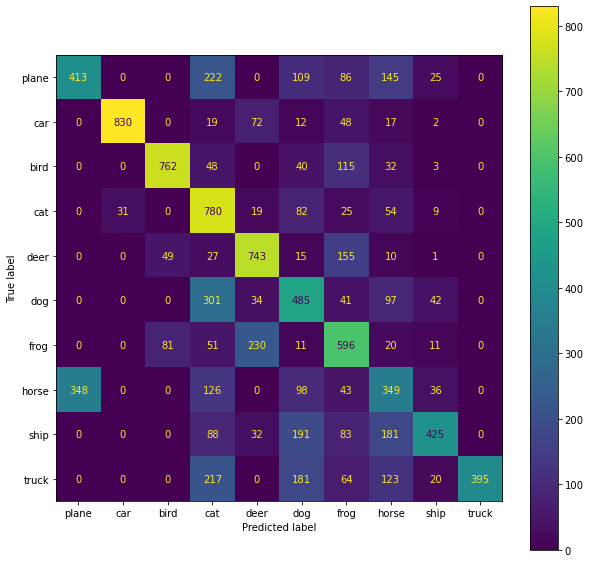

In [6]:
#Confusion and Precision & Recall metrics 

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from operator import truediv
import numpy as np

confusion_matrix = get_confusion_matrix(dpl_model, test_dataset, verbose=1)

fig, ax = plt.subplots(figsize=(10,10))

cd = ConfusionMatrixDisplay(confusion_matrix.matrix.transpose(), display_labels=classes)
cd.plot(ax=ax)

# Saving Confusion matrix for B4 model
fig.savefig("images/B4.png")


# Precision and Recall scores

cm = confusion_matrix.matrix
tp = np.diag(cm)
precision = list(map(truediv, tp, np.sum(cm, axis=0)))
recall = list(map(truediv, tp, np.sum(cm, axis=1)))
print(f"Precision {precision}\nRecall {recall}")